# READ ME
* In this approach, I've created a list with all the keypoints from the tracker results in one list i.e. id_samples
* The corresponding labels list is a boolean list of humans or not.
# Approach
* The timestamp ranges are noted where there are no humans and the split is made accordingly.
* Then the list is converted to a numpy array and both the arrays are shuffled without losing their relationship using the shuffle() that uses seed method of rand_state. The import step here is not to lose the relationship between both the arrays or else there's no point in training the neural net. 
* Next, the test train split is done and the RNN is used with 3 LSTM layers(CuDNNLSTM) for the processing of 18 keypoints with each in a list of [x,y,p(x,y)] format and two dense layers to make the prediction.
* For further details, refer the model.summary() cell which include the number of neurons per each layer. All the layers are of tf.keras
* The result is in a 2 dimensional array where result[i][0] is the probability that it's a human and result[i][1] is the probability that it is not.

In [107]:
import ndjson
import numpy as np
import random
import matplotlib.pyplot as plt

In [2]:
#opening tracker results
with open('concated.ndjson') as f:
    c_data = ndjson.load(f)

# Checking the given ndjson file's format i.e. the Tracker Results 
  # (for reference of the tracker results-rough work)

In [73]:
for c in c_data:
    val = (int)(c['id'])
    if(val == 0):
        for i in range(18):
            num = (c['frames'][0]['pose']['keypoints'][i]) #returns the 18 pose keypoints for 0th frame
            #num = (c['frames'][0]['pose']) # returns the keypoints along with the midpoint of feet
            print(num)
        break
for c in c_data:
    val = (int)(c['id'])
    if(val == 3124):
        num = len(c['frames'])
        for i in range(num):
#             print("Frame: ",i,c['frames'][i]['position'])#frame by frame position of midpoint
            print("Frame: ",i,c['frames'][i]['pose'])
            print("-------------------------------------------------------------")
        break

# Frames that don't have any humans are referred from video and is split accordingly. 
* In the context of the video, it is quite clear that there are no humans after a point of time in video. Yet, the tracker and the openpose results show the opposite. Thus, any object that has the timestamp value above 42698s i.e. beyond the 11 hours and 30 minute mark, we mark that id from the tracker result as non-human, that is, append a 0 to the label list along with it's keypoints in the sample list.
* We do the same process for humans, except we append a 1 to the label.

In [76]:
id_sample = [] #contains the keypoints along 
id_label = []  #human or not
for c in c_data:
    num = len(c['frames'])
    for i in range(num):
        time = c['frames'][i]['timestamp']
        time = int(time)
        if(time >= 42180):  #change it to your correspoding timestamp where humans stop appearing
            li = c['frames'][i]['pose']['keypoints']
            id_sample.append(li)
            id_label.append(0)

In [42]:
for c in c_data:
    num = len(c['frames'])
    for i in range(num):
        time = c['frames'][i]['timestamp']
        time = int(time)
        if(time < 42180):
            li = c['frames'][i]['pose']['keypoints']
            id_sample.append(li)
            id_label.append(1)

# Converting the lists into a numpy array for training 

In [77]:
id_sample = np.array(id_sample)
id_label = np.array(id_label)
print("Shape of sample array containing keypoints of tracker",id_sample.shape)
print("Shape of sample array containing keypoints of tracker",id_label.shape)

Shape of sample array containing keypoints of tracker (350122, 18, 3)
Shape of sample array containing keypoints of tracker (350122,)


# Shuffle both the numpy arrays
* Shuffling is done in such a way that the corresponding array elements continues to correspond, i.e. shuffle them in unison with respect to their leading indices.

In [45]:
def shuffle(a, b, seed):
   rand_state = np.random.RandomState(seed)
   rand_state.shuffle(a)
   rand_state.seed(seed)
   rand_state.shuffle(b)

In [78]:
shuffle(id_sample,id_label,12345) #Sample seed is 12345

# NORMALIZATION OF THE np ARRAY
* the most essential step- normalize the data to improve efficiency of neural net.
* After that, we split the data set into training and test set

In [47]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

In [48]:
scaler = MinMaxScaler(feature_range=(-1,1))
for i in range(len(id_sample)):
    id_sample[i] = scaler.fit_transform(id_sample[i])

In [49]:
X_train,X_test,Y_train,Y_test = train_test_split(id_sample,id_label,test_size = 0.2, random_state=4)

# RNN DEFINITION
* The RNN takes in the normalized train data and makes it run through 3 LSTM with dropouts to train it.
* CuDNNLSTM is used to utilize the GPU and make the process faster.

In [56]:
import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.compat.v1.keras.layers import CuDNNLSTM
from tensorflow.keras.optimizers import Adam

In [57]:
model = Sequential()
model.add(CuDNNLSTM(128,input_shape = (18,3), return_sequences = True))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(CuDNNLSTM(128,input_shape = (18,3), return_sequences = True))
model.add(Dropout(0.1))
model.add(BatchNormalization())
model.add(CuDNNLSTM(128,input_shape = (18,3)))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(Dense(32,activation = 'relu'))
model.add(Dropout(0.2))
model.add(Dense(2,activation = 'softmax'))

In [58]:
model.summary()

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
cu_dnnlstm_33 (CuDNNLSTM)    (None, 18, 128)           68096     
_________________________________________________________________
dropout_35 (Dropout)         (None, 18, 128)           0         
_________________________________________________________________
batch_normalization (BatchNo (None, 18, 128)           512       
_________________________________________________________________
cu_dnnlstm_34 (CuDNNLSTM)    (None, 18, 128)           132096    
_________________________________________________________________
dropout_36 (Dropout)         (None, 18, 128)           0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 18, 128)           512       
_________________________________________________________________
cu_dnnlstm_35 (CuDNNLSTM)    (None, 128)             

In [59]:
MyOp = Adam(lr = 1e-3)

In [60]:
model.compile(loss='sparse_categorical_crossentropy', optimizer=MyOp, metrics=['accuracy'])

In [61]:
ep = 10
bs = 64

In [62]:
history = model.fit(X_train,Y_train, batch_size = bs, epochs = ep, validation_data=(X_test,Y_test))

Train on 383455 samples, validate on 95864 samples
Epoch 1/10
383455/383455 [==============================] - 72s 187us/sample - loss: 0.5786 - accuracy: 0.7292 - val_loss: 0.5711 - val_accuracy: 0.7319
Epoch 2/10
383455/383455 [==============================] - 62s 163us/sample - loss: 0.5656 - accuracy: 0.7349 - val_loss: 0.5653 - val_accuracy: 0.7348
Epoch 3/10
383455/383455 [==============================] - 63s 165us/sample - loss: 0.5601 - accuracy: 0.7361 - val_loss: 0.5598 - val_accuracy: 0.7324
Epoch 4/10
383455/383455 [==============================] - 62s 163us/sample - loss: 0.5557 - accuracy: 0.7378 - val_loss: 0.5526 - val_accuracy: 0.7391
Epoch 5/10
383455/383455 [==============================] - 63s 164us/sample - loss: 0.5517 - accuracy: 0.7399 - val_loss: 0.5527 - val_accuracy: 0.7355
Epoch 6/10
383455/383455 [==============================] - 63s 163us/sample - loss: 0.5486 - accuracy: 0.7417 - val_loss: 0.5486 - val_accuracy: 0.7405
Epoch 7/10
383455/383455 [=====

In [63]:
results = model.predict(X_test) #result[n][0] --> probablity of the element being a human

In [101]:
y_pred = []
y_actual = []
human_cutoff = 0.9                        # give your desired human probabilty cutoff here. 
for i in range(len(results)):            
    if(results[i][0] > human_cutoff):     
        y_pred.append(1)
        y_actual.append(Y_test[i])
    elif(results[i][0] < (1-human_cutoff)): #the next index denotes the probabilty that it's not a human
        y_pred.append(0)
        y_actual.append(Y_test[i])

# Accuracy graph for 10 epochs

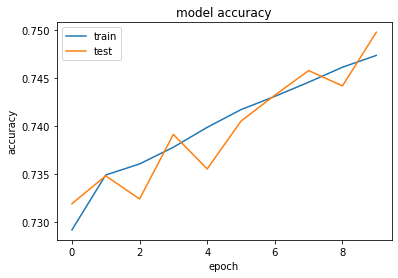

In [110]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Loss graph for 10 epochs

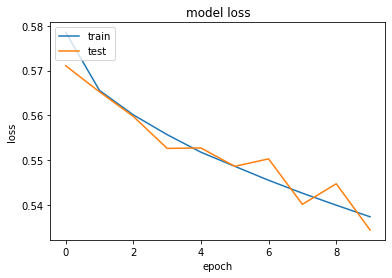

In [109]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()